In [1]:
import os

# Change where the jupyter notebook is running to acces custom packages
os.chdir('../')
print(os.getcwd())  

d:\AA_Licenta\DeepFake-detection


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torchvision.models import resnet50, resnet18
from helpers import evaluation, plotting, training
from helpers.CustomDataset import CustomDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
# PARAMS

BATCH_SIZE = 64
NUM_EPOCHS = 10
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
RANDOM_SEED = 2002

print(f"Device = {DEVICE}")

Device = cuda:0


In [4]:
# TRANSFORMS

train_transforms = transforms.Compose([
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.RandomCrop((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

test_transforms = transforms.Compose([
    torchvision.transforms.Resize((70, 70)),
    torchvision.transforms.CenterCrop((64, 64)),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [5]:
# PATHS TO DATA
TRAIN_PATH_DATA = 'data/train/'
TRAIN_PATH_CSV = 'data/train_labels.csv'
TEST_PATH_DATA = 'data/test/'
TEST_PATH_CSV = 'data/test_labels.csv'
VALID_PATH_DATA = 'data/validation/'
VALID_PATH_CSV = 'data/validation_labels.csv'

In [6]:
# Datasets

train_dataset = CustomDataset(
    TRAIN_PATH_CSV, TRAIN_PATH_DATA, train_transforms)
test_dataset = CustomDataset(
    TEST_PATH_CSV, TEST_PATH_DATA, test_transforms)
validation_dataset = CustomDataset(
    VALID_PATH_CSV, VALID_PATH_DATA, test_transforms)

In [7]:
# Dataloaders

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=True)

validation_loader = DataLoader(dataset=validation_dataset,
                               batch_size=BATCH_SIZE,
                               shuffle=True)

for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([64, 3, 224, 224])
Image label dimensions: torch.Size([64])
Class labels of 10 examples: tensor([0, 0, 1, 0, 1, 0, 0, 1, 0, 1])


In [12]:
model = resnet50()
# transform multiclass model into binary classifier
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 2)


In [13]:
#hyperparameters

loss = nn.BCELoss()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model = model.to(DEVICE)
device = next(model.parameters()).device
print(f"Model is on {device}")

Model is on cuda:0


Epoch: 001/010 | Batch 0000/0310 | Loss: 0.7119
Epoch: 001/010 | Batch 0100/0310 | Loss: 0.9284
Epoch: 001/010 | Batch 0200/0310 | Loss: 0.7164
Epoch: 001/010 | Batch 0300/0310 | Loss: 0.6114
Epoch: 001/010 | Train: 67.08% | Validation: 55.50%
Time elapsed: 51.44 min
Epoch: 002/010 | Batch 0000/0310 | Loss: 0.7034
Epoch: 002/010 | Batch 0100/0310 | Loss: 0.5607
Epoch: 002/010 | Batch 0200/0310 | Loss: 0.6130
Epoch: 002/010 | Batch 0300/0310 | Loss: 0.5724
Epoch: 002/010 | Train: 71.57% | Validation: 56.33%
Time elapsed: 101.12 min
Epoch: 003/010 | Batch 0000/0310 | Loss: 0.6023
Epoch: 003/010 | Batch 0100/0310 | Loss: 0.5001
Epoch: 003/010 | Batch 0200/0310 | Loss: 0.5258
Epoch: 003/010 | Batch 0300/0310 | Loss: 0.5348
Epoch: 003/010 | Train: 74.11% | Validation: 56.83%
Time elapsed: 150.56 min
Epoch: 004/010 | Batch 0000/0310 | Loss: 0.5822
Epoch: 004/010 | Batch 0100/0310 | Loss: 0.4413
Epoch: 004/010 | Batch 0200/0310 | Loss: 0.4953
Epoch: 004/010 | Batch 0300/0310 | Loss: 0.4538
Ep

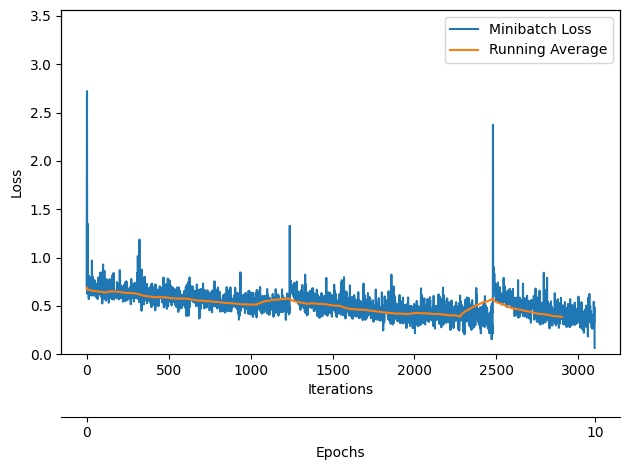

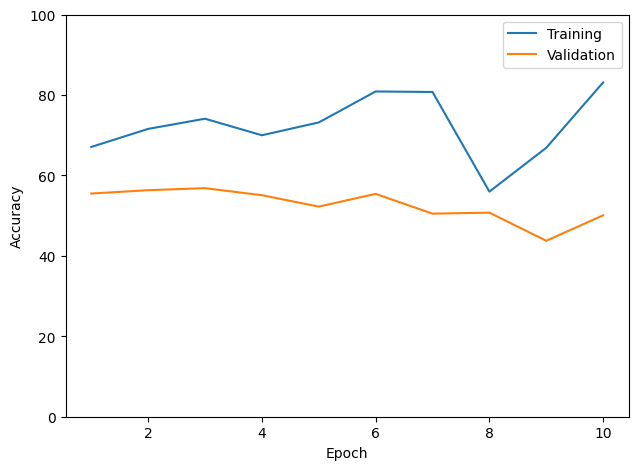

In [14]:
minibatch_loss_list, train_acc_list, valid_acc_list = training.train_model(
    model=model,

    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,

    valid_loader=validation_loader,
    test_loader=test_loader,

    optimizer=optimizer,

    device=DEVICE,

    logging_interval=100)


plotting.plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=200)

plt.show()


plotting.plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)

plt.ylim([0, 100])

plt.show()

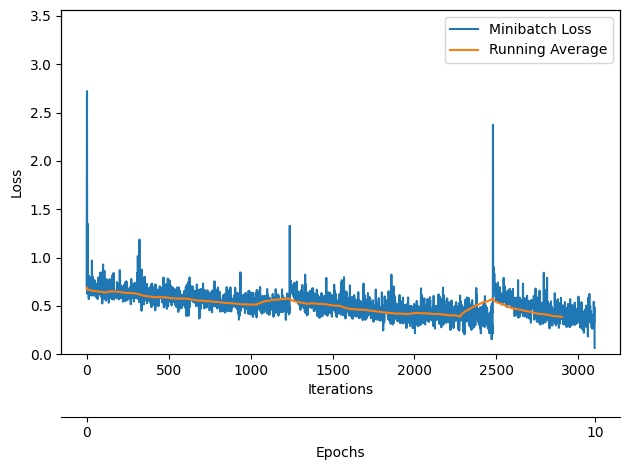

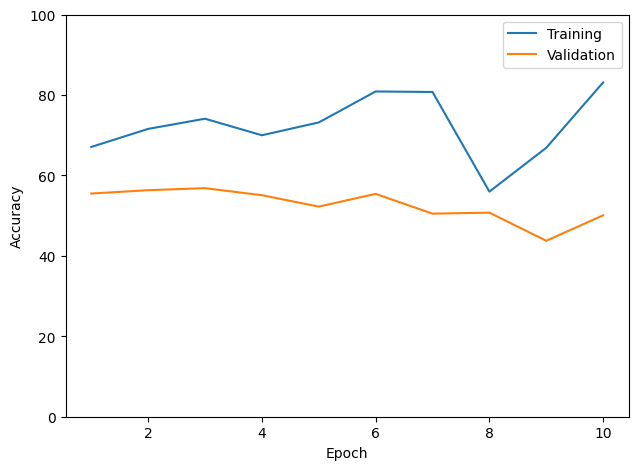

In [19]:
plotting.plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                            num_epochs=NUM_EPOCHS,
                            iter_per_epoch=len(train_loader),
                            results_dir=None,
                            averaging_iterations=200)
plt.savefig("./plots/resnet50_no_weights-train-loss.png")
plt.show()


plotting.plot_accuracy(train_acc_list=train_acc_list,
                       valid_acc_list=valid_acc_list,
                       results_dir=None)

plt.ylim([0, 100])
plt.savefig("./plots/resnet50_no_weights-accuracy.png", dpi=300)
plt.show()

In [24]:
confusion_matrix = evaluation.compute_confusion_matrix(model, test_loader, device=DEVICE)

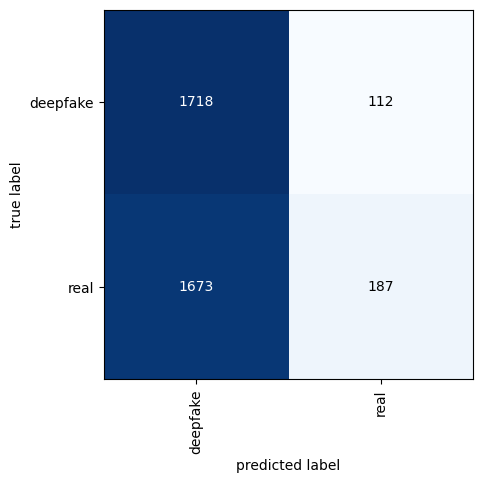

In [27]:
fig, _ = plotting.plot_confusion_matrix(confusion_matrix, class_names=['deepfake', 'real'])

plt.savefig("./plots/resnet50_no_weights-confusion-matrix.png", dpi=300)

In [28]:
torch.save(model, 'baseline.pth')